<a href="https://colab.research.google.com/github/Malekkamoua/PFE/blob/main/5_Forecasting_%7C_ML_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot

%matplotlib inline

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install wandb -qqq
import wandb
wandb.login()

     |████████████████████████████████| 1.8 MB 7.5 MB/s 
     |████████████████████████████████| 145 kB 48.8 MB/s 
     |████████████████████████████████| 181 kB 56.8 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/Datascience/PFE/datasets/addixo_final_dataset_fs_db.csv')

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Normalization
values = df[['duration']].values

# Normalization
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(values)

In [ ]:
def create_data(series, prev_instances = 4):
 
    X_train_1 = pd.DataFrame(series).astype('float64')
    X_train_temp = X_train_1.shift(1)
    y_label = X_train_1.shift(-1)
    
    data = pd.concat([X_train_temp, X_train_1, y_label], axis=1)
    
    for r in range(prev_instances-2):
        X_train_temp = X_train_temp.shift(1)
        data = pd.concat([X_train_temp, data], axis=1)
    data.dropna(inplace = True)
    data.reset_index(drop = True, inplace = True)
    # print(data.head(10))
    X = data.iloc[:, 0:-1].values 
    y = data.iloc[:,-1].values 
    
    print('This series takes {} previous instances'.format(prev_instances))
    
    data.columns = [*data.columns[:-1], 'y']
    
    return data, X, y

In [ ]:
WINDOW_SIZE = 5

time_series = scaled_data;
data, X, y = create_data(time_series, prev_instances = WINDOW_SIZE)

This series takes 5 previous instances


In [ ]:
# 70% 15% 15%

X_train, y_train = X[:57153], y[:57153]
X_test, y_test = X[57153:69400], y[57153:69400]
X_val, y_val = X[69400:], y[69400:]
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((57153, 5), (57153,), (12247, 5), (12247,), (12284, 5), (12284,))

In [ ]:
from statsmodels.tsa.stattools import acf

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  
    mae = np.mean(np.abs(forecast - actual))    
    rmse = np.mean((forecast - actual)**2)**.5  

    return mape, mae, rmse

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Forecasting with XGBOOST

In [ ]:
from math import sqrt
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error as MSE

sweep_xgboost_config = {
    "method": "random", # try grid or random
    "metric": {
      "name": "MAPE",
      "goal": "minimize"   
    },
    "parameters": {
        "booster": {
            "values": ["gbtree","gblinear"]
        },
        "max_depth": {
            "values": [ 7, 9, 12]
        },
        "n_estimators": {
            "values": [50, 100, 200]
        },
        "learning_rate": {
            "values": [0.01, 0.025]
        },
        "subsample": {
            "values": [1, 0.5, 0.3]
        },
        "colsample_bytree": {
            "values": [0.3, 0.7]
        }
    }
}

sweep_xgboost_id = wandb.sweep(sweep_xgboost_config, project="XGBoost_shot_6")

def xgboost_train():
  config_defaults = {
      'n_estimators': 200,
      "booster": "gbtree",
      "max_depth": 3,
      "learning_rate": 0.1,
      "colsample_bytree": 0.3
    }

  wandb.init(config=config_defaults)  # defaults are over-ridden during the sweep
  config = wandb.config

  model = XGBRegressor(n_estimators = config.n_estimators,
                      booster = config.booster,
                      max_depth = config.max_depth,
                      learning_rate = config.learning_rate,
                      objective ='reg:squarederror',
                      verbosity = 0)

  model.fit(X_train, y_train)

  predictions_test = model.predict(X_test)
  mape, mae, rmse = forecast_accuracy(y_test, predictions_test)
  print(mape, mae, rmse)

  wandb.log({"MAPE": mape})

wandb.agent(sweep_xgboost_id, xgboost_train, count=40)

In [ ]:
import time
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators = 200,
                     max_depth = 9,
                     subsample =0.3,
                     booster='gbtree',
                     learning_rate = 0.025,
                     colsample_bytree = 0.3,
                     objective ='reg:squarederror',
                     verbosity = 0)
start = time.time()
model.fit(X_train, y_train)
stop = time.time()

print(f"Training time: {stop - start}s")

predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)
predictions_val = model.predict(X_val)

Training time: 5.393847703933716s


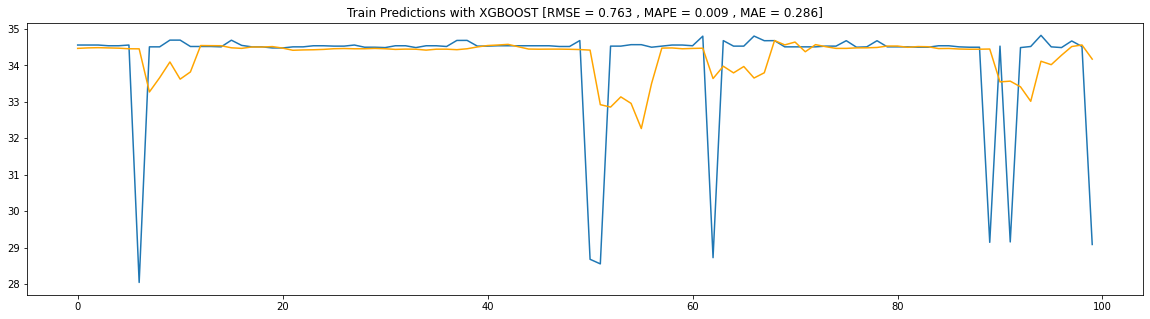

In [ ]:
y_pred_train_xgb = model.predict(np.asarray(X_train).astype('float32'))
Inverse_y_train = y_train.reshape(-1,1)
Inverse_y_train = scaler.inverse_transform(Inverse_y_train)
Inverse_y_pred_train_xgb = y_pred_train_xgb.reshape(-1,1)
Inverse_y_pred_train_xgb = scaler.inverse_transform(Inverse_y_pred_train_xgb)

mape, mae, rmse = forecast_accuracy(Inverse_y_train, Inverse_y_pred_train_xgb)

fig, ax = plt.subplots(figsize=(20,5))

# plot forecasts against actual outcomes
pyplot.plot(Inverse_y_train[0:100])
pyplot.plot(Inverse_y_pred_train_xgb[0:100], color='orange')
plt.title("Train Predictions with XGBOOST [RMSE = %.3f , MAPE = %.3f , MAE = %.3f]" % (rmse, mape, mae) )
pyplot.show()

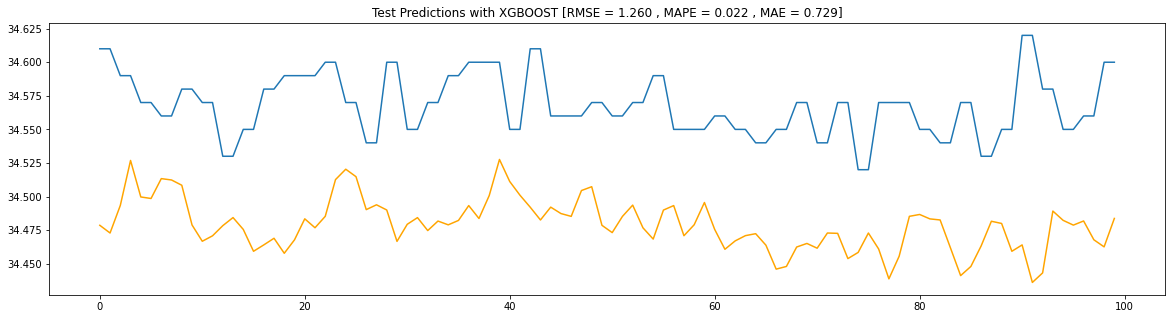

In [ ]:
y_pred_test_xgb = model.predict(np.asarray(X_test).astype('float32'))
Inverse_y_test = y_test.reshape(-1,1)
Inverse_y_test = scaler.inverse_transform(Inverse_y_test)
Inverse_y_pred_test_xgb = y_pred_test_xgb.reshape(-1,1)
Inverse_y_pred_test_xgb = scaler.inverse_transform(Inverse_y_pred_test_xgb)

y_pred_test_xgb.shape, Inverse_y_pred_test_xgb.shape, Inverse_y_test.shape

mape, mae, rmse = forecast_accuracy(Inverse_y_test, Inverse_y_pred_test_xgb)

fig, ax = plt.subplots(figsize=(20,5))

# plot forecasts against actual outcomes
pyplot.plot(Inverse_y_test[0:100])
pyplot.plot(Inverse_y_pred_test_xgb[0:100], color='orange')
plt.title("Test Predictions with XGBOOST [RMSE = %.3f , MAPE = %.3f , MAE = %.3f]" % (rmse, mape, mae) )
pyplot.show()

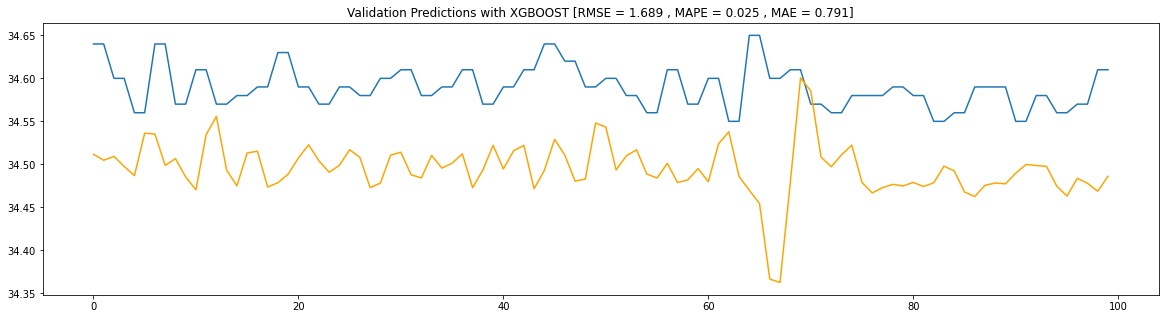

In [ ]:
y_pred_val_xgb = model.predict(np.asarray(X_val).astype('float32'))
Inverse_y_val = y_val.reshape(-1,1)
Inverse_y_val = scaler.inverse_transform(Inverse_y_val)
Inverse_y_pred_val_xgb = y_pred_val_xgb.reshape(-1,1)
Inverse_y_pred_val_xgb = scaler.inverse_transform(Inverse_y_pred_val_xgb)

y_pred_val_xgb.shape, Inverse_y_pred_val_xgb.shape, Inverse_y_val.shape

mape, mae, rmse = forecast_accuracy(Inverse_y_val, Inverse_y_pred_val_xgb)

fig, ax = plt.subplots(figsize=(20,5))

# plot forecasts against actual outcomes
pyplot.plot(Inverse_y_val[0:100])
pyplot.plot(Inverse_y_pred_val_xgb[0:100], color='orange')
plt.title("Validation Predictions with XGBOOST [RMSE = %.3f , MAPE = %.3f , MAE = %.3f]" % (rmse, mape, mae) )
pyplot.show()

## Forecasting with RandomForest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

sweep_rf_config = {
    "method": "random", # try grid or random
    "metric": {
      "name": "MAPE",
      "goal": "minimize"   
    },
    "parameters": {
        "max_depth": {
            "values": [2, 3, 6, 7, 9, 12]
        },
        "n_estimators": {
            "values": [50, 100, 200]
        },
        
        "max_features": {
            "values": ['auto']
        },
        "min_samples_split": {
            "values": [3, 5, 7]
        }
    }
}

sweep_rf_id = wandb.sweep(sweep_rf_config, project="RandomForest_shot_5")

def rf_train():
  config_defaults = {
      'n_estimators': 200,
      "max_depth": 3,
      "max_features": 'auto',
      "min_samples_split": 3
    }

  wandb.init(config=config_defaults)  # defaults are over-ridden during the sweep
  config = wandb.config

  model = RandomForestRegressor(n_estimators = config.n_estimators,
                                max_depth = config.max_depth,
                                min_samples_split = config.min_samples_split,
                                max_features= config.max_features)

  model.fit(X_train, y_train)

  predictions_test = model.predict(X_test)
  mape, mae, rmse = forecast_accuracy(y_test, predictions_test)
  print(mape, mae, rmse)

  wandb.log({"MAPE": mape})

wandb.agent(sweep_rf_id, rf_train, count=40)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100,
                              max_features='auto',
                              min_samples_split = 7,
                              max_depth = 6)

start = time.time()
model.fit(X_train, y_train)
stop = time.time()

print(f"Training time: {stop - start}s")

Training time: 6.7462756633758545s


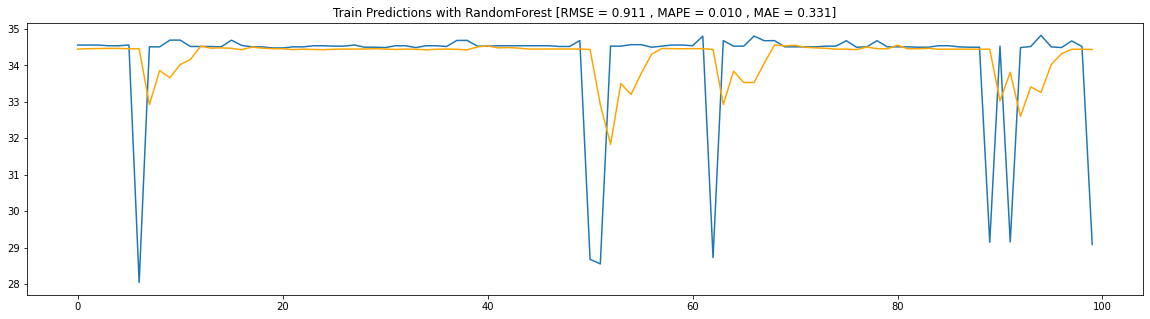

In [ ]:
y_pred_train_rf = model.predict(np.asarray(X_train).astype('float32'))
Inverse_y_train = y_train.reshape(-1,1)
Inverse_y_train = scaler.inverse_transform(Inverse_y_train)
Inverse_y_pred_train_rf = y_pred_train_rf.reshape(-1,1)
Inverse_y_pred_train_rf = scaler.inverse_transform(Inverse_y_pred_train_rf)

y_pred_train_rf.shape, Inverse_y_pred_train_rf.shape, Inverse_y_train.shape

mape, mae, rmse = forecast_accuracy(Inverse_y_train, Inverse_y_pred_train_rf)

fig, ax = plt.subplots(figsize=(20,5))

# plot forecasts against actual outcomes
pyplot.plot(Inverse_y_train[0:100])
pyplot.plot(Inverse_y_pred_train_rf[0:100], color='orange')
plt.title("Train Predictions with RandomForest [RMSE = %.3f , MAPE = %.3f , MAE = %.3f]" % (rmse, mape, mae) )
pyplot.show()

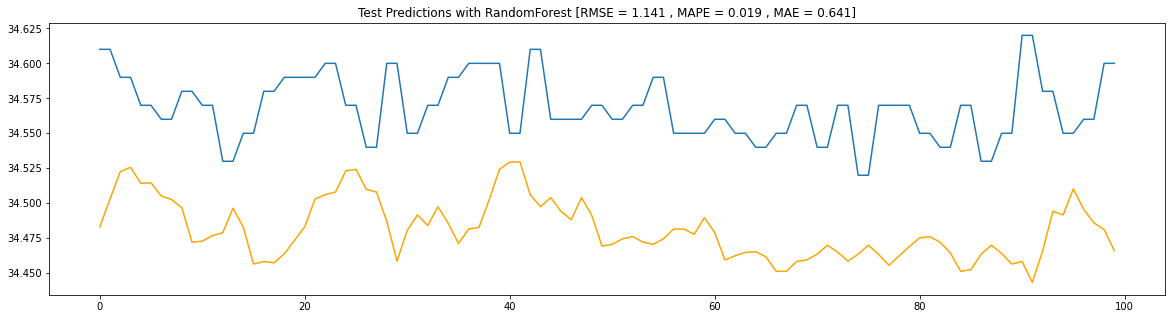

In [ ]:
y_pred_test_rf = model.predict(np.asarray(X_test).astype('float32'))
Inverse_y_test = y_test.reshape(-1,1)
Inverse_y_test = scaler.inverse_transform(Inverse_y_test)
Inverse_y_pred_test_rf = y_pred_test_rf.reshape(-1,1)
Inverse_y_pred_test_rf = scaler.inverse_transform(Inverse_y_pred_test_rf)

y_pred_test_rf.shape, Inverse_y_pred_test_rf.shape, Inverse_y_test.shape

mape, mae, rmse = forecast_accuracy(Inverse_y_test, Inverse_y_pred_test_rf)

fig, ax = plt.subplots(figsize=(20,5))

# plot forecasts against actual outcomes
pyplot.plot(Inverse_y_test[0:100])
pyplot.plot(Inverse_y_pred_test_rf[0:100], color='orange')
plt.title("Test Predictions with RandomForest [RMSE = %.3f , MAPE = %.3f , MAE = %.3f]" % (rmse, mape, mae) )
pyplot.show()

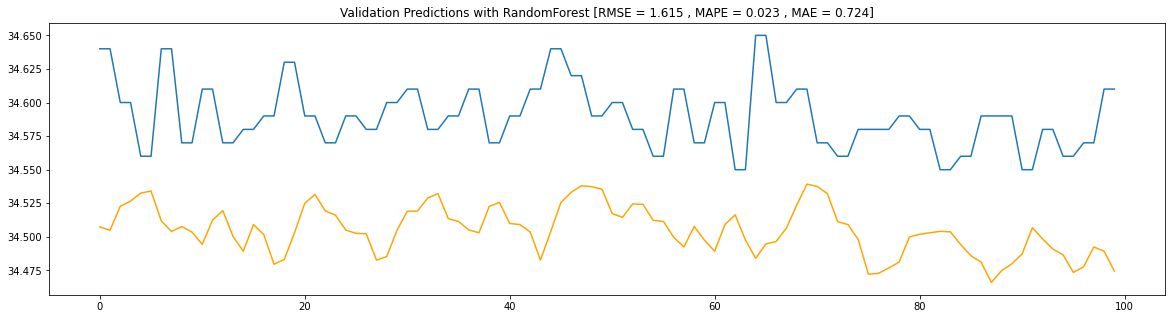

In [ ]:
y_pred_val_rf = model.predict(np.asarray(X_val).astype('float32'))
Inverse_y_val = y_val.reshape(-1,1)
Inverse_y_val = scaler.inverse_transform(Inverse_y_val)
Inverse_y_pred_val_rf = y_pred_val_rf.reshape(-1,1)
Inverse_y_pred_val_rf = scaler.inverse_transform(Inverse_y_pred_val_rf)

y_pred_val_rf.shape, Inverse_y_pred_val_rf.shape, Inverse_y_val.shape

mape, mae, rmse = forecast_accuracy(Inverse_y_val, Inverse_y_pred_val_rf)

fig, ax = plt.subplots(figsize=(20,5))

# plot forecasts against actual outcomes
pyplot.plot(Inverse_y_val[0:100])
pyplot.plot(Inverse_y_pred_val_rf[0:100], color='orange')
plt.title("Validation Predictions with RandomForest [RMSE = %.3f , MAPE = %.3f , MAE = %.3f]" % (rmse, mape, mae) )
pyplot.show()